In [397]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns

In [398]:
def f(x):
    """真实函数"""
    return 2 * torch.sin(x) + x ** 0.8


def plot_kernel_reg(y_hat):
    plt.scatter(x_train, y_train)
    plt.plot(x_test, y_truth, color='red', label='truth')
    plt.plot(x_train, y_hat, color='orange', label='pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

In [399]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # 训练样本的输入
noise = torch.normal(0.0, 0.5, (n_train,))
y_train = f(x_train) + noise  # 训练样本的输出

# 用于模拟真实曲线
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出

基于平均汇聚来计算所有训练样本输出值的平均值:

$$ f(x)=\frac{1}{n} \sum_{i=1}^{n} y_{i} $$

In [400]:
# 使用训练样本输出值的平均值拟合曲线
y_hat = torch.repeat_interleave(y_train.mean(), len(x_test))
y_hat

tensor([2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675,
        2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675,
        2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675,
        2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675,
        2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675, 2.5675,
        2.5675, 2.5675, 2.5675, 2.5675, 2.5675])

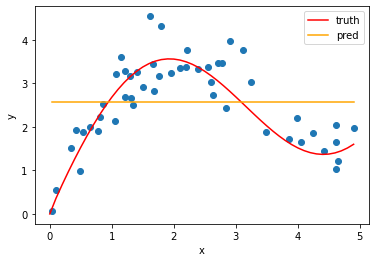

In [401]:
plot_kernel_reg(y_hat)

根据输⼊的位置对输出$ y_i $进⾏加权:

$$ f(x)=\sum_{i=1}^{n} \frac{K\left(x-x_{i}\right)}{\sum_{j=1}^{n} K\left(x-x_{j}\right)} y_{i}$$

其中$K$为核函数

可以从注意力机制的⻆度重写上式,成为⼀个更加通用的注意⼒汇聚(attention pooling)公式:

$$ f(x)=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} $$

其中$x$是查询,$(x_i, y_i)$是键值对.注意⼒汇聚是$y_i$的加权平均.将查询$x$和键$x_i$之间的关系建模为注意力
权重(attetnion weight)$\alpha(x; x_i)$,如上式所示,这个权重将被分配给每⼀个对应值$y_i$.
对于任何查询,模型在所有键值对上的注意⼒权重都是⼀个有效的概率分布:它们是⾮负数的,并且总和为1.

下面考虑核函数为高斯核(Gaussian kernel),其定义为:

$$ K(u)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{u^{2}}{2}\right) $$

代入上式,即

\begin{aligned}
f(x) &=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} \\
&=\sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}\left(x-x_{j}\right)^{2}\right)} y_{i} \\
&=\sum_{i=1}^{n} \operatorname{softmax}\left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right) y_{i}
\end{aligned}

由上式可知,如果⼀个键$x_i$越是接近给定的查询$x$,那么分配给这个键对应值$y_i$的注意⼒权重就会越⼤,也就是"获得了更多的注意⼒".

tensor([[0.0410, 0.0410, 0.0410,  ..., 0.0410, 0.0410, 0.0410],
        [0.1071, 0.1071, 0.1071,  ..., 0.1071, 0.1071, 0.1071],
        [0.3399, 0.3399, 0.3399,  ..., 0.3399, 0.3399, 0.3399],
        ...,
        [4.6223, 4.6223, 4.6223,  ..., 4.6223, 4.6223, 4.6223],
        [4.6450, 4.6450, 4.6450,  ..., 4.6450, 4.6450, 4.6450],
        [4.9086, 4.9086, 4.9086,  ..., 4.9086, 4.9086, 4.9086]])


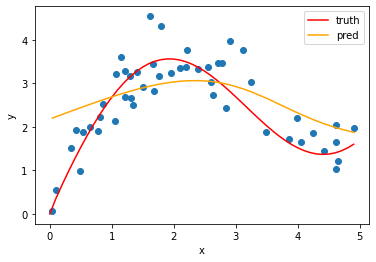

In [402]:
# 每行元素相同;X_repeat.shape(n_train, n_trian)
X_repeat = torch.unsqueeze(x_train, 1).repeat(1, n_train)
print(X_repeat)
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)  # 广播机制
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

Text(33.0, 0.5, 'Sorted testing inputs')

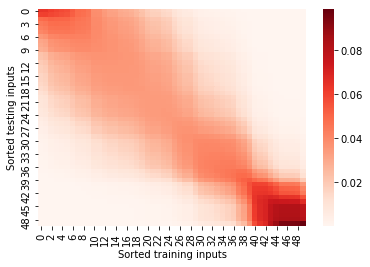

In [403]:
# 观察可知"查询-键"对越接近,注意⼒汇聚的注意⼒权重就越高
_, axes = plt.subplots(1, 1)
sns.heatmap(attention_weights, cmap='Reds', ax=axes)
axes.set_xlabel('Sorted training inputs')
axes.set_ylabel('Sorted testing inputs')

下⾯的查询$ x $和键$x_i $之间的距离乘以可学习参数$w$:

\begin{aligned}
f(x) &=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} \\
&=\sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right)} y_{i} \\
&=\sum_{i=1}^{n} \operatorname{softmax}\left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right) y_{i}
\end{aligned}

In [404]:
class NWKernelRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # 学习参数w
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        queries = torch.unsqueeze(queries, 1).repeat(1, keys.shape[1])
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2, dim=1)
        print(self.attention_weights.unsqueeze(1).shape, values.unsqueeze(-1).shape)  # 使之可以进行矩阵乘法
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [405]:
# X_tile.shape(n_train, n_train),每⼀⾏都包含着相同的训练输⼊
X_tile = x_train.repeat((n_train, 1))
# Y_tile.shape=(n_train, n_train),每⼀⾏都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys.shape=(n_train, n_train-1)
keys = X_tile[(1 - torch.eye(n_train)).to(dtype=torch.bool)].reshape((n_train, -1))  # 去除对角线处的元素
# values.shape=(n_train, n_train-1)
values = Y_tile[(1 - torch.eye(n_train)).to(dtype=torch.bool)].reshape((n_train, -1))

In [406]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
for epoch in range(10):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')

torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 1, loss 23.823229
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 2, loss 6.792572
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 3, loss 6.763235
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 4, loss 6.742071
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 5, loss 6.726145
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 6, loss 6.713809
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 7, loss 6.704060
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 8, loss 6.696228
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 9, loss 6.689871
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 10, loss 6.684662


torch.Size([50, 1, 50]) torch.Size([50, 50, 1])


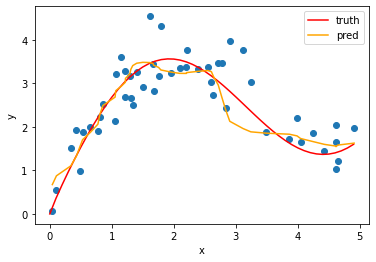

In [407]:
keys = x_train.repeat((50, 1))
values = y_train.repeat((50, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

Text(33.0, 0.5, 'Sorted testing inputs')

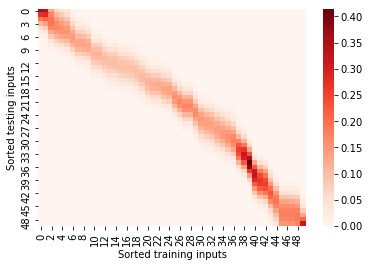

In [408]:
_, axes = plt.subplots(1, 1)
sns.heatmap(net.attention_weights.detach(), cmap='Reds', ax=axes)
axes.set_xlabel('Sorted training inputs')
axes.set_ylabel('Sorted testing inputs')
